In [1]:
from pyspark.sql import functions as F
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import folium
from folium.plugins import HeatMap, MarkerCluster
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2
import sys; 
import sys; sys.path.insert(0, 'lib/')
from libs import utils

In [3]:
data_path = "data/Crime_Data_from_2020_to_Present_20241013.csv"
# Read and Clean Data
df = utils.prepare_data(data_path)
# Additional feature engineering - add more features
df = utils.feature_engineering(df)
columns_drop = ["AREA NAME", "Rpt Dist No", "Part 1-2", "Crm Cd", "Crm Cd Desc", "Mocodes", "Premis Cd","Premis Desc", "Weapon Used Cd", "Weapon Desc", "Status Desc", "LOCATION", "age_group"]
df_dropped = utils.drop_columns(df, columns_drop)
df_dropped = df_dropped.drop("DATE OCC", "TIME OCC", "datetime_str", "Date Rptd")
df_clean = df_dropped.dropna(subset=["Vict Age"])


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/20 23:03:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/20 23:03:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/20 23:03:07 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
df_pd = df_clean.toPandas()
df_pd_encoded = pd.get_dummies(df_pd, columns=["Vict Sex", "Vict Descent", "Status", "Category"], drop_first=True)
df_pd_encoded

,AREA,Vict Age,LAT,LON,Year OCC,Month OCC,Day OCC,Vict Sex_M,Vict Sex_X,Vict Descent_Asian Indian,...,Category_MVT (GTA),Category_OTHER THEFT,Category_PERSONAL THFT,Category_RAPE,Category_ROBBERY,Category_SIMPLE ASSAULT,Category_SIMPLE ASSAULT (DV),Category_Trespassing,Category_Unknown,Category_Vandalism
0,1,47,34.0444,-118.2628,2020,2,8,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3,19,34.0210,-118.3002,2020,11,4,False,True,False,...,False,True,False,False,False,False,False,False,False,False
2,9,19,34.1576,-118.4387,2020,3,10,True,False,False,...,False,True,False,False,False,False,False,False,False,False
3,6,28,34.0944,-118.3277,2020,8,17,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,18,41,33.9467,-118.2463,2020,12,1,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722901,16,36,34.2271,-118.3878,2024,1,13,True,False,False,...,False,False,False,False,False,False,False,False,False,False
722902,21,44,34.2260,-118.6214,2024,2,17,False,False,False,...,False,False,False,False,False,False,False,False,False,False
722903,20,80,34.0690,-118.3054,2024,1,16,False,False,False,...,False,False,False,False,False,True,False,False,False,False
722904,20,36,34.0617,-118.3066,2024,8,17,False,False,False,...,False,True,False,False,False,False,False,False,False,False


24/10/20 23:03:19 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [8]:
dbscan = DBSCAN(eps=3, min_samples = 10)
clusters = dbscan.fit_predict(df_pd_encoded)

In [9]:
labels = dbscan.labels_
df_pd_encoded["cluster"] = labels
hotspots = df_pd_encoded[df_pd_encoded["cluster"]!=-1]
heatmap_data = list(zip(hotspots['LAT'], hotspots['LON']))

In [10]:
m =  folium.Map(location=[hotspots['LAT'].mean(), hotspots['LON'].mean()], zoom_start=12)

# Add the heatmap layer
HeatMap(heatmap_data, radius=15, blur=10).add_to(m)
filename = f"heatmaps/crime_hotspots_all_dbscan_3.html"
# Show the map (or save to file)
m.save(filename)

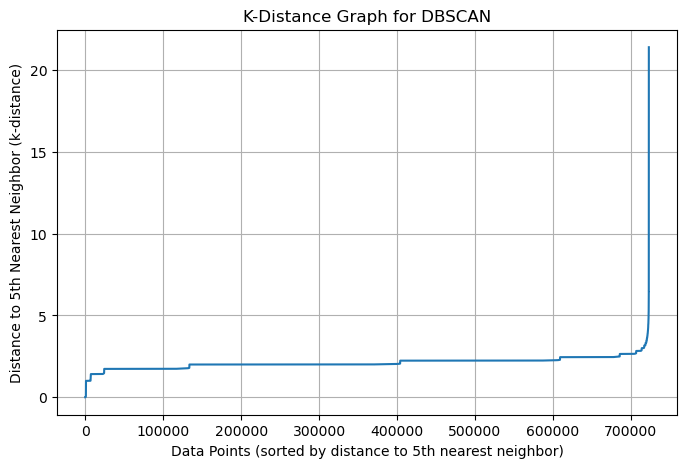

In [17]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_pd_encoded)

distances, indices = neighbors_fit.kneighbors(df_pd_encoded)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-Distance Graph for DBSCAN')
plt.xlabel('Data Points (sorted by distance to 5th nearest neighbor)')
plt.ylabel('Distance to 5th Nearest Neighbor (k-distance)')
plt.grid(True)
plt.show()
